In [ ]:
"""
V4 incluye doblado con FFT y suavizado con Savizky-Golay (recomendable solo p/calibraciones de baja estadística)
El archivo ".mos" o ".Asc" de entrada no debe tener encabezado
Preparando para Colab e importando librerías necesarias.
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/MuestrasLuis/SSKFP_M12/4460.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Parameters, minimize, fit_report
from scipy.constants import *
from scipy.integrate import trapz
from scipy.signal import savgol_filter
from pathlib import Path

path= Path(img); name= path.stem; title= path.parent.name; full= path.parents[0]; print(name, title, full)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
Mounted at /content/drive/
4460 SSKFP_M12 /content/drive/MyDrive/Colab-Notebooks/PyMossFit/MuestrasLuis/SSKFP_M12


Ingrese la fecha de calibración (AAAAMMDD): 20240719
Ingrese el rango de V (en mm/s): 6.0


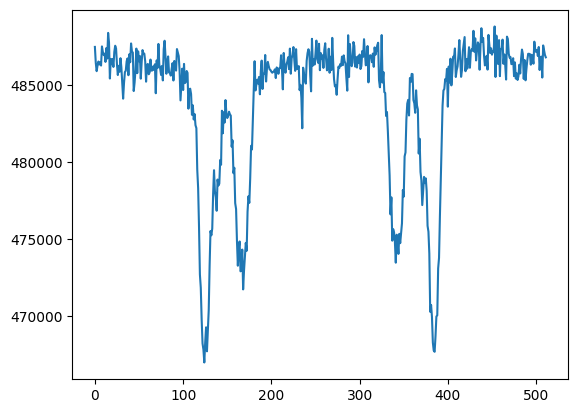

256


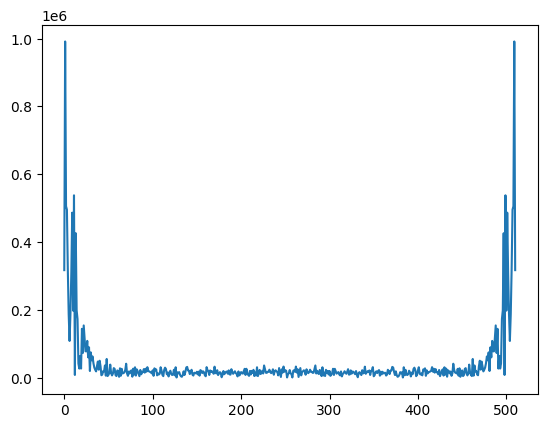

972870


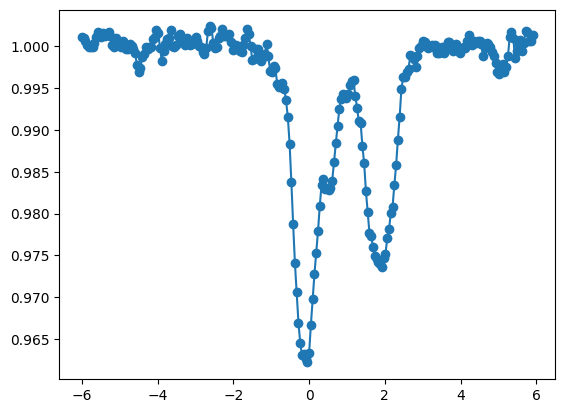

In [ ]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de CNEA de 512 canales
"""
y= np.loadtxt(img, delimiter=" "); y=y[:,1] #agregar delimiter="," o delimiter=" " en loadtxt si es de dos columnas. Caso contrario comentar y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )
np.savetxt(f"{full}/{name}_calib.txt", (fecha,vel, N), fmt='%s')

#y= savgol_filter(y, 5, 2) #solo si se trata de espectro con baja estadística, comentar en otro caso
plt.plot(y)
plt.show()

"""
Doblado con FFT
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-5:N2+5]).idxmax()+(N2-5); print(Nf)
plt.plot(f[1:N])
plt.show()

for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[N-1-i]]

y=y[0:N2-1]
"""
Normalización
"""
y2= np.concatenate([y[2:30],y[N2-30:N2-2]])

ymax=np.mean(y2)
ymax=int(ymax)

print(ymax)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,N2)
y= savgol_filter(y, 5, 2)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{name}_calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{name}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

<ipython-input-4-651a0ce620c7>:78: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  int1= trapz(1-z1, x); int2= trapz(1-z2, x)


ancho1 (sigma1/sqrt(2)) es: 0.28 mm/s
Centroide1 (ISO1) es: 0.221 mm/s
Amplitud1 (a1) es: 0.0072
Doblete1 es: 0.796 mm/s
área1: 23.5 %
ancho dist(sigma2/sqrt(2)) es: -0.07 mm/s
Centroide2 (ISO2) es: 0.337 mm/s
Amplitud2 (av) es: 0.01
Dist doblete es: 1.928 mm/s
área2: 76.5 %
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 351
    # data points      = 255
    # variables        = 10
    chi-square         = 3.4187e-04
    reduced chi-square = 1.3954e-06
    Akaike info crit   = -3428.19854
    Bayesian info crit = -3392.78590
[[Variables]]
    b1:  0.39059227 +/- 0.02485301 (6.36%) (init = 0.35)
    m1:  0.22084335 +/- 0.00891859 (4.04%) (init = -0.03)
    d1:  0.79629482 +/- 0.02045889 (2.57%) (init = 0.8)
    a1:  0.00715017 +/- 3.6679e-04 (5.13%) (init = 0.1)
    av:  0.01 (fixed)
    bl:  0.90150859 +/- 0.00499993 (0.55%) (init = 0.65)
    bg: -0.09377551 +/- 0.05613364 (59.86%) (init = 0.65)
    mv:  0.33685177 +/- 0.00505830 (1.50%) (init = 1.2)


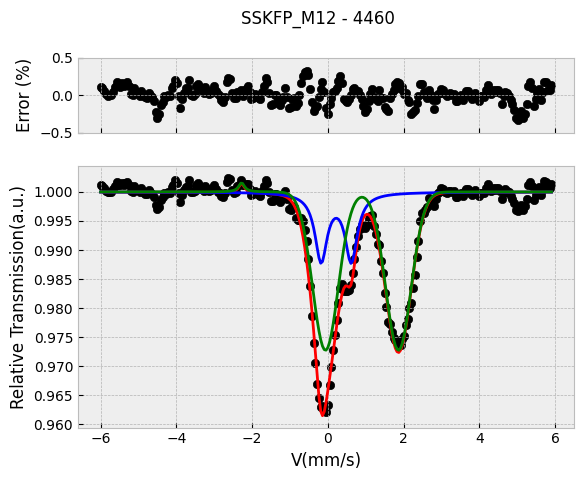

In [ ]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{name}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES BASADAS EN LORENTZIANAS y VOIGTIANAS
"""
def singlet(a, b, m, x):
    return 2*a*b/(pi*(b**2+4*(x-m)**2))

def doublet(a, b, m, d, x):
    return 2*a*b/(pi*(b**2+4*(x-(m-d/2))**2))+2*a*b/(pi*(b**2+4*(x-(m+d/2))**2))

def sextet(a, b, m, d, q, l23, x):
    return 6*a*b/(pi*(b**2+4*(x-(m+5*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m+3*d-q))**2))+2.5*a*b/(pi*(b**2+4*(x-(m+0.75*d))**2))+2.5*a*b/(pi*(b**2+4*(x-(m-0.75*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m-3*d+q))**2))+6*a*b/(pi*(b**2+4*(x-(m-5*d))**2))

def voigt_d(av, mv, bl, bg, dl, dg, x):
      return 2*av*bl/(pi*(bl**2+(x-4*(mv-dl/2))**2))+2*av*bl/(pi*(bl**2+(x-4*(mv+dl/2))**2))+(1-av)*np.exp(-(x-(mv-dg/2))**2/(2*bg**2))/(bg*np.sqrt(2*np.pi))+(1-av)*np.exp(-(x-(mv+dg/2))**2/(2*bg**2))/(bg*np.sqrt(2*np.pi))

def linear_fitting_lmfit(params, x, y):
    b1= params['b1']; m1= params['m1']; d1= params['d1']; a1= params['a1']
    mv= params['mv']
    bl= params['bl']
    dl= params['dl']
    av= params['av']
    s= params['s']
    bg= params['bg']
    dg= params['dg']
    y_fit= 1-(doublet(a1, b1, m1, d1, x))-(s*voigt_d(av, bl, bg, mv, dl, dg, x))

    return y_fit-y

"""
AJUSTE DE LOS PARÁMETROS USANDO LOS DATOS EXPERIMENTALES
"""
params= Parameters()

params.add('b1', value= 0.35, vary=True)
params.add('m1', value= -0.03, vary=True)
params.add('d1', value= 0.8, vary=True)
params.add('a1', value= 0.1, vary=True)
params.add('av', value= 0.01, vary=False)
params.add('bl', value= 0.65, vary=True)
params.add('bg', value= 0.65, vary=True)
params.add('mv', value= 1.2, vary=True)
params.add('dg', value= 2.05, vary=True)
params.add('dl', value= 2.05, vary=True)
params.add('s', value= 0.08, vary=True)

fitted_params= minimize(linear_fitting_lmfit, params, args=(x, y,), method='least_square')

m1= fitted_params.params['m1'].value
b1= fitted_params.params['b1'].value
d1= fitted_params.params['d1'].value
a1= fitted_params.params['a1'].value
mv= fitted_params.params['mv'].value
bl= fitted_params.params['bl'].value
bg= fitted_params.params['bg'].value
dl= fitted_params.params['dl'].value
dg= fitted_params.params['dg'].value
av= fitted_params.params['av'].value
s= fitted_params.params['s'].value

"""
CREACIÓN DE LOS SUBESPECTROS AJUSTADOS
"""
z= 1-(doublet(a1, b1, m1, d1, x))-(s*voigt_d(av, bl, bg, mv, dl, dg, x))
z1= 1-(doublet(a1, b1, m1, d1, x))
z2= 1-(s*voigt_d(av, bl, bg, mv, dl, dg, x))
e= (y-z)/y*100

"""
INTEGRAL DE ÁREAS Y GENERACIÓN DE LOS PARÁMETROS HIPERFINOS. REPORTE EN PANTALLA
"""
int1= trapz(1-z1, x); int2= trapz(1-z2, x)

b1= "{0:.2f}".format(b1/np.sqrt(2))
m1= "{0:.3f}".format(m1)
d1= "{0:.3f}".format(d1)
a1= "{0:.4f}".format(a1)
i1= "{0:.1f}".format(100*abs(int1/(int1+int2)))
bl= "{0:.2f}".format(bl/np.sqrt(2))
bg= "{0:.2f}".format(bg/np.sqrt(2))
mv= "{0:.3f}".format(mv)
dl= "{0:.3f}".format(dl)
dg= "{0:.3f}".format(dg)
#a2= "{0:.4f}".format(a2)
i2= "{0:.1f}".format(100*abs(int2/(int1+int2)))


print('ancho1 (sigma1/sqrt(2)) es:', b1, 'mm/s')
print('Centroide1 (ISO1) es:', m1, 'mm/s')
print('Amplitud1 (a1) es:', a1)
print('Doblete1 es:', d1, 'mm/s')
print('área1:', i1, '%')
print('ancho dist(sigma2/sqrt(2)) es:', bg, 'mm/s')
print('Centroide2 (ISO2) es:', mv, 'mm/s')
print('Amplitud2 (av) es:', abs(av))
print('Dist doblete es:', dg, 'mm/s')
print('área2:', i2, '%')
print(fit_report(fitted_params))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle(f"{title}" " - " f"{name}")
ax1.scatter (x, e, c= 'black')
ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel('Error (%)')

ax2.scatter (x, y, c= 'black')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Transmission(a.u.)')
ax2.plot(x, z, c='red')
ax2.plot(x, z1, c='blue')
ax2.plot(x, z2, c='green')

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt(f"{full}/{name}-plot.csv", list(zip(x,y, z, z1, z2)), fmt='%1.6e')

df= pd.DataFrame ({'Ancho(mm/s)': [b1, bl], 'ISO (mm/s)': [m1, mv], 'Quadrupolar shift': [d1, dl], 'Área(%)': [i1, i2]})
df.to_csv(f"{full}/{name}_report.csv", index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')